In [26]:
import pandas as pd
import numpy as np

ACADEMIC_PATH = r'../../data/raw/academic_records.csv'
ADMISSION_PATH = r'../../data/raw/admission.csv'
TEST_PATH = r'../../data/raw/test.csv'
academic_records = pd.read_csv(ACADEMIC_PATH)
admission = pd.read_csv(ADMISSION_PATH)

In [27]:
import pandas as pd
import numpy as np
import re

# --- HÀM MỚI: Xử lý định dạng học kỳ phức tạp ---
def parse_semester_string(sem_str):
    """
    Chuyển đổi chuỗi như 'HK1 2023-2024' thành mã số 20231 để sort được.
    Logic: Năm * 10 + Kỳ
    """
    s = str(sem_str).strip()
    
    # Trường hợp 1: Dạng số sẵn (VD: 20231)
    if s.isdigit():
        return int(s)
    
    # Trường hợp 2: Dạng chữ (VD: HK1 2023-2024 hoặc Học kỳ 1 năm 2023)
    # Tìm tất cả các con số trong chuỗi
    digits = re.findall(r'\d+', s)
    
    if len(digits) >= 2:
        # Giả sử số nhỏ là kỳ, số lớn (4 chữ số) là năm
        # Tìm năm (thường là số có 4 chữ số đầu tiên tìm thấy)
        years = [int(d) for d in digits if len(d) == 4]
        sems = [int(d) for d in digits if len(d) == 1]
        
        if years and sems:
            year = years[0]
            sem = sems[0]
            return year * 10 + sem
            
    return 0 # Không xác định

def clean_data_pipeline_v3(admission, academic_records):
    print("--- 🚀 BẮT ĐẦU QUY TRÌNH LÀM SẠCH DỮ LIỆU (FIXED VERSION) ---")
    
    adm = admission.copy()
    acad = academic_records.copy()
    
    # 1. Chuẩn hóa ID
    adm['MA_SO_SV'] = adm['MA_SO_SV'].astype(str)
    acad['MA_SO_SV'] = acad['MA_SO_SV'].astype(str)
    
    # ---------------------------------------------------------
    # [FIX QUAN TRỌNG] Xử lý HOC_KY thông minh hơn
    # ---------------------------------------------------------
    print("-> Đang xử lý cột HOC_KY...")
    # Tạo cột HOC_KY_INT dùng để sort (VD: 20231)
    acad['HOC_KY_INT'] = acad['HOC_KY'].apply(parse_semester_string)
    
    # Kiểm tra xem có dòng nào bị lỗi (bằng 0) không
    error_count = (acad['HOC_KY_INT'] == 0).sum()
    if error_count > 0:
        print(f"   ⚠️ Cảnh báo: Có {error_count} dòng không đọc được HOC_KY.")

    # Merge dữ liệu
    df = pd.merge(acad, adm, on='MA_SO_SV', how='left')
    
    # Sắp xếp theo Time-series chuẩn xác dựa trên cột vừa tạo
    df = df.sort_values(by=['MA_SO_SV', 'HOC_KY_INT']).reset_index(drop=True)
    
    # ---------------------------------------------------------
    # 2. XỬ LÝ SỐ LIỆU & LOGIC
    # ---------------------------------------------------------
    cols_float = ['GPA', 'CPA', 'DIEM_TRUNGTUYEN', 'DIEM_CHUAN']
    cols_int = ['TC_DANGKY', 'TC_HOANTHANH']
    
    for col in cols_float:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        
    for col in cols_int:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

    # Logic: Hoàn thành <= Đăng ký
    df['TC_HOANTHANH'] = np.minimum(df['TC_HOANTHANH'], df['TC_DANGKY'])
    
    # Target Transformation
    df['COMPLETION_RATE'] = df['TC_HOANTHANH'] / (df['TC_DANGKY'] + 1e-9)
    df['COMPLETION_RATE'] = df['COMPLETION_RATE'].clip(0, 1)

    # Clip điểm số
    df['GPA'] = df['GPA'].clip(0, 4.0)
    df['CPA'] = df['CPA'].clip(0, 4.0)

    # Admission Gap Feature
    if 'DIEM_TRUNGTUYEN' in df.columns and 'DIEM_CHUAN' in df.columns:
        df['ADMISSION_GAP'] = df['DIEM_TRUNGTUYEN'] - df['DIEM_CHUAN']
    
    # Lọc rác
    initial_len = len(df)
    df = df[df['TC_DANGKY'] > 0]
    
    print(f"--- ✅ HOÀN TẤT. Kích thước data: {df.shape} ---")
    print("Sample HOC_KY_INT:", df['HOC_KY_INT'].head().tolist())
    
    return df

# Chạy thử lại
df_clean = clean_data_pipeline_v3(admission, academic_records)
df_clean.head()

--- 🚀 BẮT ĐẦU QUY TRÌNH LÀM SẠCH DỮ LIỆU (FIXED VERSION) ---
-> Đang xử lý cột HOC_KY...
--- ✅ HOÀN TẤT. Kích thước data: (105726, 14) ---
Sample HOC_KY_INT: [20231, 20232, 20211, 20212, 20221]


,MA_SO_SV,HOC_KY,CPA,GPA,TC_DANGKY,TC_HOANTHANH,HOC_KY_INT,NAM_TUYENSINH,PTXT,TOHOP_XT,DIEM_TRUNGTUYEN,DIEM_CHUAN,COMPLETION_RATE,ADMISSION_GAP
0,00003e092652,HK1 2023-2024,1.64,1.97,18,15,20231,2023,100,A00,21.32,20.25,0.833333,1.07
1,00003e092652,HK2 2023-2024,1.53,2.05,18,13,20232,2023,100,A00,21.32,20.25,0.722222,1.07
2,000e15519006,HK1 2021-2022,3.85,3.85,9,9,20211,2021,1,D07,23.84,22.43,1.000000,1.41
3,000e15519006,HK2 2021-2022,2.77,3.12,19,19,20212,2021,1,D07,23.84,22.43,1.000000,1.41
4,000e15519006,HK1 2022-2023,2.83,2.98,21,21,20221,2021,1,D07,23.84,22.43,1.000000,1.41


In [28]:
import pandas as pd
import numpy as np
import re

# ==============================================================================
# 1. CÁC HÀM TIỆN ÍCH (UTILS)
# ==============================================================================

def parse_semester_string(sem_str):
    """
    Chuyển đổi 'HK1 2023-2024' -> 20231 (Int) để sort time-series.
    """
    s = str(sem_str).strip()
    if s.isdigit(): return int(s)
    
    digits = re.findall(r'\d+', s)
    if len(digits) >= 2:
        years = [int(d) for d in digits if len(d) == 4]
        sems = [int(d) for d in digits if len(d) == 1]
        if years and sems:
            return years[0] * 10 + sems[0]
    return 0

def fast_slope(y):
    """
    Tính hệ số góc (Trend) nhanh.
    Input: Array numpy (có thể chứa NaN).
    """
    # Lọc bỏ NaN trước khi tính (Quan trọng!)
    y_clean = y[~np.isnan(y)]
    n = len(y_clean)
    if n < 2: return 0.0
    
    x = np.arange(n)
    x_mean = np.mean(x)
    y_mean = np.mean(y_clean)
    
    numerator = np.sum((x - x_mean) * (y_clean - y_mean))
    denominator = np.sum((x - x_mean) ** 2)
    
    return numerator / (denominator + 1e-6)

# ==============================================================================
# 2. DATA PREPROCESSING PIPELINE
# ==============================================================================

def clean_data_pipeline(admission, academic_records, is_test=False):
    print("--- 🚀 1. PREPROCESSING DATA ---")
    adm = admission.copy()
    acad = academic_records.copy()
    
    # Chuẩn hóa ID
    adm['MA_SO_SV'] = adm['MA_SO_SV'].astype(str)
    acad['MA_SO_SV'] = acad['MA_SO_SV'].astype(str)
    
    # Tạo Time-Index
    acad['semester_order'] = acad['HOC_KY'].apply(parse_semester_string)
    
    # Merge
    df = pd.merge(acad, adm, on='MA_SO_SV', how='left')
    
    # Sort Time-Series (CỰC KỲ QUAN TRỌNG)
    df = df.sort_values(by=['MA_SO_SV', 'semester_order']).reset_index(drop=True)
    
    # Numeric conversion
    cols_float = ['GPA', 'CPA', 'DIEM_TRUNGTUYEN', 'DIEM_CHUAN']
    cols_int = ['TC_DANGKY', 'TC_HOANTHANH']
    
    for col in cols_float:
        if col in df.columns: df[col] = pd.to_numeric(df[col], errors='coerce')
    for col in cols_int:
        if col in df.columns: df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

    # Logic clean
    if not is_test:
        df['TC_HOANTHANH'] = np.minimum(df['TC_HOANTHANH'], df['TC_DANGKY'])
        df['GPA'] = df['GPA'].clip(0, 4.0)
        df['CPA'] = df['CPA'].clip(0, 4.0)
    
    # Target Transformation (Chỉ dùng cho train)
    if not is_test:
        df['COMPLETION_RATE'] = df['TC_HOANTHANH'] / (df['TC_DANGKY'] + 1e-9)
        df['COMPLETION_RATE'] = df['COMPLETION_RATE'].clip(0, 1)

    return df

# ==============================================================================
# 3. FEATURE ENGINEERING CLASS (CORE)
# ==============================================================================

class FeatureEngineer:    
    def __init__(self):
        # Các cột Category sẽ giữ lại
        self.cat_cols = ['PTXT', 'TOHOP_XT', 'MA_NGANH', 'KV_UT', 'KHOA_VIEN'] 

    def create_features(self, df):
        print("--- ⚡ 2. FEATURE ENGINEERING (FULL POWER) ---")
        df = df.copy()
        
        # Sort lại cho chắc chắn
        df = df.sort_values(['MA_SO_SV', 'semester_order']).reset_index(drop=True)
        
        # Convert Category
        for col in self.cat_cols:
            if col in df.columns:
                df[col] = df[col].astype(str).astype('category')

        # Groupby object
        g = df.groupby('MA_SO_SV')

        # ---------------------------------------------------------
        # A. BASE LAGS (Cực kỳ quan trọng: Dùng shift(1) để tránh Leakage)
        # ---------------------------------------------------------
        # Tạo biến Raw (chứa NaN) để tính toán thống kê chính xác hơn
        df['Prev_GPA_Raw'] = g['GPA'].shift(1)
        
        # Tạo biến Fill (để model dùng trực tiếp)
        df['Prev_GPA'] = df['Prev_GPA_Raw'].fillna(-1)
        df['Prev_CPA'] = g['CPA'].shift(1).fillna(-1)
        df['Prev_TC_HOANTHANH'] = g['TC_HOANTHANH'].shift(1).fillna(0)
        df['Prev_TC_DANGKY'] = g['TC_DANGKY'].shift(1).fillna(0)
        
        # Cờ năm nhất (Chưa có lịch sử)
        df['is_freshman'] = (df['Prev_TC_DANGKY'] == 0).astype(int)

        # ---------------------------------------------------------
        # B. GỌI CÁC NHÓM FEATURE
        # ---------------------------------------------------------
        df = self._create_admission_features(df)
        df = self._create_history_features(df)
        df = self._create_trend_features(df)  # <--- Slope, Volatility nằm ở đây
        df = self._create_risk_features(df)
        
        # Dọn dẹp cột tạm
        if 'Prev_GPA_Raw' in df.columns:
            df = df.drop(columns=['Prev_GPA_Raw'])
            
        return df

    def _create_admission_features(self, df):
        # Khoảng cách điểm đầu vào
        if 'DIEM_TRUNGTUYEN' in df.columns and 'DIEM_CHUAN' in df.columns:
            df['diem_vuot_chuan'] = df['DIEM_TRUNGTUYEN'] - df['DIEM_CHUAN']
        
        # Tuổi (giả định năm hiện tại 2025/2026)
        if 'NAM_TUYENSINH' in df.columns:
            df['nam_tuoi'] = 2026 - df['NAM_TUYENSINH']
            
        # Số kỳ đã học (tính từ năm nhập học)
        df['semester_number'] = df.groupby('MA_SO_SV').cumcount() + 1
        return df

    def _create_history_features(self, df):
        # 1. Delta GPA-CPA: Đang học tốt hơn hay tệ hơn trung bình tích lũy?
        df['prev_gpa_cpa_diff'] = df['Prev_GPA'] - df['Prev_CPA']
        
        # 2. Tỷ lệ hoàn thành kỳ trước
        df['prev_completion_rate'] = df['Prev_TC_HOANTHANH'] / (df['Prev_TC_DANGKY'] + 1e-9)
        
        # 3. Load Factor (Áp lực): Đăng ký kỳ này / Sức học trung bình
        avg_capacity = df.groupby('MA_SO_SV')['Prev_TC_HOANTHANH'].transform(
            lambda x: x.rolling(window=5, min_periods=1).mean()
        ).fillna(15)
        
        df['load_factor'] = df['TC_DANGKY'] / (avg_capacity + 1e-9)
        
        # Biến cờ: Rớt môn kỳ trước
        df['failed_last_sem'] = (df['Prev_TC_HOANTHANH'] < df['Prev_TC_DANGKY']).astype(int)
        
        return df

    def _create_trend_features(self, df):
        # Sử dụng Prev_GPA_Raw (có NaN) để tính Slope chính xác
        # Nếu dùng Prev_GPA (có -1), Slope sẽ bị sai lệch lớn
        g_raw = df.groupby('MA_SO_SV')['Prev_GPA_Raw']
        
        # 1. GPA Slope (Xu hướng điểm)
        df['gpa_trend_slope'] = g_raw.transform(
            lambda x: x.rolling(window=3, min_periods=2).apply(fast_slope, raw=True)
        ).fillna(0)
        
        # 2. [RECOVERED] GPA Volatility (Độ ổn định)
        df['gpa_volatility'] = g_raw.transform(
            lambda x: x.rolling(window=4, min_periods=2).std()
        ).fillna(0)
        
        # 3. Tích lũy tín chỉ (History)
        grouped = df.groupby('MA_SO_SV')
        cum_dangky = grouped['Prev_TC_DANGKY'].cumsum()
        cum_hoanthanh = grouped['Prev_TC_HOANTHANH'].cumsum()
        
        df['total_credits_failed'] = cum_dangky - cum_hoanthanh
        df['accumulated_fail_ratio'] = df['total_credits_failed'] / (cum_dangky + 1e-9)
        
        # 4. [RECOVERED] Credit Velocity (Tốc độ học)
        semester_count = grouped.cumcount() + 1
        df['credit_velocity'] = cum_hoanthanh / semester_count
        
        return df

    def _create_risk_features(self, df):
        # Hành vi "Gỡ gạc" (Aggressive Recovery): Rớt môn kỳ trước -> Đăng ký nhiều hơn kỳ này
        more_credits = (df['TC_DANGKY'] > df['Prev_TC_DANGKY'])
        df['aggressive_recovery'] = (df['failed_last_sem'] & more_credits).astype(int)
        
        # Kỳ vọng hoàn thành (Expected Credits) = Đăng ký * Tỷ lệ đậu toàn cục của SV đó
        df['expected_real_credits'] = df['TC_DANGKY'] * (1 - df['accumulated_fail_ratio'])
        
        return df

    def get_feature_columns(self, df):
        """Tự động lấy danh sách feature dựa trên prefix"""
        
        # Whitelist các prefix
        valid_prefixes = [
            'Prev_', 'prev_', 'sem_', 'diem_', 'nam_', 'is_', 
            'load_', 'aggressive_', 'gpa_', 'total_', 'accumulated_',
            'credit_', 'expected_', 'failed_'
        ]
        
        valid_exact = ['TC_DANGKY', 'DIEM_TRUNGTUYEN', 'DIEM_CHUAN', 'semester_number']
        valid_exact.extend(self.cat_cols)
        
        final_cols = []
        # Các cột target/meta cần loại bỏ
        ignore_cols = ['TC_HOANTHANH', 'GPA', 'CPA', 'semester_order', 'MA_SO_SV', 'HOC_KY', 'COMPLETION_RATE', 'Prev_GPA_Raw']
        
        for col in df.columns:
            if col in ignore_cols: continue
            
            is_valid = False
            if col in valid_exact: is_valid = True
            else:
                for prefix in valid_prefixes:
                    if col.startswith(prefix):
                        is_valid = True
                        break
            
            if is_valid: final_cols.append(col)
                
        return final_cols

# ==============================================================================
# 4. EXECUTION BLOCK (CHẠY THỬ)
# ==============================================================================


test_raw = pd.read_csv(TEST_PATH)

print("--- BẮT ĐẦU PIPELINE ---")

# 1. Clean Data
df_train_raw = clean_data_pipeline(admission, academic_records, is_test=False)

# 2. Chuẩn bị Test (Gán dummy values để chạy được pipeline)
test_copy = test_raw.copy()
for col in ['TC_HOANTHANH', 'GPA', 'CPA']: test_copy[col] = 0
df_test_raw = clean_data_pipeline(admission, test_copy, is_test=True)

# 3. Gộp Train + Test để tạo feature (Tránh biên giới giữa các kỳ bị đứt gãy)
df_train_raw['set_type'] = 'TRAIN'
df_test_raw['set_type'] = 'TEST'
full_df = pd.concat([df_train_raw, df_test_raw], ignore_index=True)

# 4. Feature Engineering
fe = FeatureEngineer()
full_df_fe = fe.create_features(full_df)

# 5. Tách lại Train/Test
train_final = full_df_fe[full_df_fe['set_type'] == 'TRAIN'].copy()
test_final = full_df_fe[full_df_fe['set_type'] == 'TEST'].copy()

# 6. Lấy features & Target
feature_cols = fe.get_feature_columns(train_final)
X = train_final[feature_cols]
y = train_final['TC_HOANTHANH'] # Hoặc dùng COMPLETION_RATE nếu muốn

print(f"✅ Xong! Số lượng Features: {len(feature_cols)}")
print(f"Sample Features: {feature_cols[:5]}")

--- BẮT ĐẦU PIPELINE ---
--- 🚀 1. PREPROCESSING DATA ---
--- 🚀 1. PREPROCESSING DATA ---
--- ⚡ 2. FEATURE ENGINEERING (FULL POWER) ---
✅ Xong! Số lượng Features: 24
Sample Features: ['TC_DANGKY', 'PTXT', 'TOHOP_XT', 'DIEM_TRUNGTUYEN', 'DIEM_CHUAN']


In [19]:
import pandas as pd
import numpy as np

# Giữ lại hàm tính slope của bạn vì nó viết rất tốt
def fast_slope(y):
    if len(y) < 2: return 0.0
    x = np.arange(len(y))
    x_mean, y_mean = np.mean(x), np.mean(y)
    numerator = np.sum((x - x_mean) * (y - y_mean))
    denominator = np.sum((x - x_mean) ** 2)
    return numerator / (denominator + 1e-6)

class FeatureEngineer:
    def __init__(self):
        # Các cột Category có thể có
        self.cat_cols = ['PTXT', 'TOHOP_XT', 'MA_NGANH', 'KV_UT', 'KHOA_VIEN'] 

    def create_features(self, df):
        print("   -> ⚡ Đang kích hoạt chế độ tạo Feature: FULL POWER...")
        df = df.copy()
        
        # Sort dữ liệu
        df = df.sort_values(['MA_SO_SV', 'HOC_KY_INT']).reset_index(drop=True)
        
        # Chuyển đổi category
        for col in self.cat_cols:
            if col in df.columns:
                df[col] = df[col].astype(str).astype('category')

        # Group theo SV
        g = df.groupby('MA_SO_SV')

        # =========================================================
        # 1. BASIC LAGS (Qúa khứ liền kề)
        # =========================================================
        df['Prev_GPA'] = g['GPA'].shift(1).fillna(-1)
        df['Prev_CPA'] = g['CPA'].shift(1).fillna(-1)
        df['Prev_TC_HOANTHANH'] = g['TC_HOANTHANH'].shift(1).fillna(0)
        df['Prev_TC_DANGKY'] = g['TC_DANGKY'].shift(1).fillna(0)
        
        # Tỷ lệ hoàn thành kỳ trước
        df['Prev_RATE'] = df['Prev_TC_HOANTHANH'] / (df['Prev_TC_DANGKY'] + 1e-9)
        
        # [MỚI] GAP GPA-CPA: Sinh viên đang học tốt hơn hay tệ hơn tích lũy?
        # > 0: Đang tiến bộ vượt bậc | < 0: Đang kéo điểm xuống
        df['GAP_GPA_CPA'] = df['Prev_GPA'] - df['Prev_CPA']

        # =========================================================
        # 2. TREND & VOLATILITY (Xu hướng & Độ ổn định)
        # =========================================================
        # Trend GPA (Slope)
        df['GPA_SLOPE'] = g['GPA'].transform(
            lambda x: x.rolling(window=3, min_periods=2).apply(fast_slope, raw=True)
        ).fillna(0)
        
        # [MỚI] Độ biến động (Volatility): Sinh viên học "tài tử" hay ổn định?
        # Std càng cao -> Càng khó đoán -> Rủi ro cao
        df['GPA_VOLATILITY'] = g['GPA'].transform(
            lambda x: x.rolling(window=4, min_periods=2).std()
        ).fillna(0)

        # =========================================================
        # 3. HISTORY ACCUMULATION (Lịch sử "chinh chiến")
        # =========================================================
        cum_dangky = g['TC_DANGKY'].cumsum().shift(1).fillna(0)
        cum_hoanthanh = g['TC_HOANTHANH'].cumsum().shift(1).fillna(0)
        
        df['TOTAL_CREDITS_HISTORY'] = cum_dangky
        df['TOTAL_FAILED'] = cum_dangky - cum_hoanthanh
        df['FAIL_RATIO_HISTORY'] = df['TOTAL_FAILED'] / (cum_dangky + 1e-9)
        
        # [MỚI] Tốc độ tín chỉ (Credit Velocity)
        # Trung bình mỗi kỳ sinh viên "nuốt" được bao nhiêu tín?
        # (Dùng số kỳ đã học để chia)
        semester_count = g.cumcount() # Đếm số kỳ đã qua (0, 1, 2...)
        df['CREDIT_VELOCITY'] = cum_hoanthanh / (semester_count + 1e-9)

        # =========================================================
        # 4. RISK & PRESSURE (Rủi ro & Áp lực kỳ này)
        # =========================================================
        # Load Factor
        avg_capacity = g['TC_HOANTHANH'].transform(
            lambda x: x.rolling(window=5, min_periods=1).mean()
        ).shift(1).fillna(15)
        
        df['LOAD_FACTOR'] = df['TC_DANGKY'] / (avg_capacity + 1e-9)
        
        # Cờ rớt môn kỳ trước
        df['FAILED_LAST_SEM'] = (df['Prev_TC_HOANTHANH'] < df['Prev_TC_DANGKY']).astype(int)
        
        # Is Aggressive: Rớt môn nhưng vẫn đăng ký nhiều hơn?
        df['IS_AGGRESSIVE'] = ((df['FAILED_LAST_SEM'] == 1) & 
                               (df['TC_DANGKY'] > df['Prev_TC_DANGKY'])).astype(int)
        
        # [MỚI] Cờ tân sinh viên (Năm nhất)
        # Dùng để model xử lý riêng nhóm chưa có lịch sử
        first_year = g['HOC_KY_INT'].transform('min') // 10
        current_year = df['HOC_KY_INT'] // 10
        df['YEAR_NUM'] = current_year - first_year + 1
        df['IS_FRESHMAN'] = (df['YEAR_NUM'] == 1).astype(int)

        return df

# --- PIPELINE THỰC THI ---

print("--- 🔄 BẮT ĐẦU FEATURE ENGINEERING (FINAL) ---")

# 1. Đọc dữ liệu (Giả sử bạn đã chạy clean_data_pipeline_v3 ở trên cho cả Train và Test)
# Lưu ý: Cần chạy lại đoạn đọc Test nếu chưa có
test_raw = pd.read_csv(TEST_PATH)
for col in ['TC_HOANTHANH', 'GPA', 'CPA']: test_raw[col] = 0
test_clean = clean_data_pipeline_v3(admission, test_raw)

# 2. Đánh dấu
df_clean['set_type'] = 'TRAIN'
test_clean['set_type'] = 'TEST'

# 3. Ghép (Sandwich)
full_flow = pd.concat([df_clean, test_clean], ignore_index=True)

# 4. Tạo Feature
fe = FeatureEngineer()
full_fe = fe.create_features(full_flow)

# 5. Tách lại
train_final = full_fe[full_fe['set_type'] == 'TRAIN'].copy()
test_final = full_fe[full_fe['set_type'] == 'TEST'].copy()

# 6. Dọn dẹp cột thừa
drop_cols = ['set_type', 'HOC_KY', 'NAM_TUYENSINH']
train_final.drop(columns=drop_cols, errors='ignore', inplace=True)
test_final.drop(columns=drop_cols, errors='ignore', inplace=True)

# Lấy danh sách feature cuối cùng
ignore = ['MA_SO_SV', 'TC_HOANTHANH', 'COMPLETION_RATE', 'HOC_KY_INT', 'GPA', 'CPA']
features = [c for c in train_final.columns if c not in ignore]

print(f"\n✅ XONG! Số lượng features: {len(features)}")
print(f"Danh sách: {features}")
print(f"Kích thước Train: {train_final.shape}, Test: {test_final.shape}")

--- 🔄 BẮT ĐẦU FEATURE ENGINEERING (FINAL) ---
--- 🚀 BẮT ĐẦU QUY TRÌNH LÀM SẠCH DỮ LIỆU (FIXED VERSION) ---
-> Đang xử lý cột HOC_KY...
--- ✅ HOÀN TẤT. Kích thước data: (16502, 14) ---
Sample HOC_KY_INT: [20241, 20241, 20241, 20241, 20241]
   -> ⚡ Đang kích hoạt chế độ tạo Feature: FULL POWER...

✅ XONG! Số lượng features: 23
Danh sách: ['TC_DANGKY', 'PTXT', 'TOHOP_XT', 'DIEM_TRUNGTUYEN', 'DIEM_CHUAN', 'ADMISSION_GAP', 'Prev_GPA', 'Prev_CPA', 'Prev_TC_HOANTHANH', 'Prev_TC_DANGKY', 'Prev_RATE', 'GAP_GPA_CPA', 'GPA_SLOPE', 'GPA_VOLATILITY', 'TOTAL_CREDITS_HISTORY', 'TOTAL_FAILED', 'FAIL_RATIO_HISTORY', 'CREDIT_VELOCITY', 'LOAD_FACTOR', 'FAILED_LAST_SEM', 'IS_AGGRESSIVE', 'YEAR_NUM', 'IS_FRESHMAN']
Kích thước Train: (105726, 29), Test: (16502, 29)


--- 🤖 BẮT ĐẦU GIAI ĐOẠN TRAINING ---
📌 Kích thước tập Train: (90582, 29)
📌 Kích thước tập Valid: (15144, 29) (Các kỳ sau 20231)
🚀 Số lượng features thực tế: 22
Features: ['PTXT', 'TOHOP_XT', 'DIEM_TRUNGTUYEN', 'DIEM_CHUAN', 'ADMISSION_GAP', 'Prev_GPA', 'Prev_CPA', 'Prev_TC_HOANTHANH', 'Prev_TC_DANGKY', 'Prev_RATE', 'GAP_GPA_CPA', 'GPA_SLOPE', 'GPA_VOLATILITY', 'TOTAL_CREDITS_HISTORY', 'TOTAL_FAILED', 'FAIL_RATIO_HISTORY', 'CREDIT_VELOCITY', 'LOAD_FACTOR', 'FAILED_LAST_SEM', 'IS_AGGRESSIVE', 'YEAR_NUM', 'IS_FRESHMAN']

--- ⚡ TRAINING LIGHTGBM ---

--- 🌳 TRAINING XGBOOST ---

📊 KẾT QUẢ VALIDATION (MỤC TIÊU: CÀNG THẤP CÀNG TỐT)
   - LightGBM RMSE: 3.7224
   - XGBoost RMSE:  3.7023
   - Ensemble RMSE: 3.7015 🔥


/var/folders/7q/mzsxqp0j31v2vfhlflpzkt9w0000gn/T/ipykernel_31997/1410464445.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_df, x='Importance', y='Feature', palette='viridis')


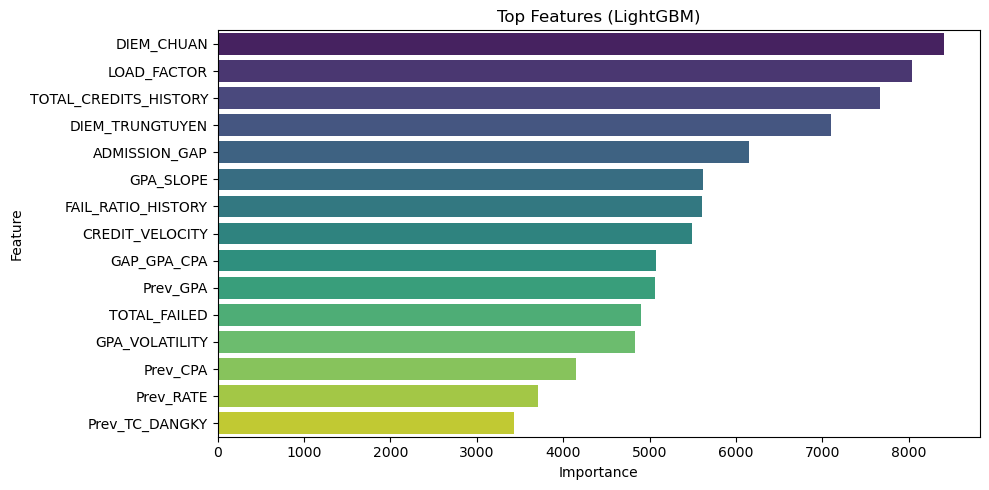

In [20]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

print("--- 🤖 BẮT ĐẦU GIAI ĐOẠN TRAINING ---")

# =========================================================
# 1. SPLIT DATA (Tách Train - Valid theo thời gian)
# =========================================================
# Theo đề bài: 
# Train: Đến hết HK1 năm 2023-2024 (Mã: 20231)
# Valid: HK2 năm 2023-2024 (Mã: 20232)

SPLIT_TERM = 20231 

# train_final đang chứa cả Train + Valid (từ bước Feature Engineering trước)
train_df = train_final[train_final['HOC_KY_INT'] <= SPLIT_TERM].copy()
valid_df = train_final[train_final['HOC_KY_INT'] > SPLIT_TERM].copy()

print(f"📌 Kích thước tập Train: {train_df.shape}")
print(f"📌 Kích thước tập Valid: {valid_df.shape} (Các kỳ sau {SPLIT_TERM})")

# =========================================================
# 2. CHUẨN BỊ FEATURES & TARGET
# =========================================================
ignore_cols = [
    'MA_SO_SV', 'TC_HOANTHANH', 'COMPLETION_RATE', 
    'HOC_KY_INT', 'GPA', 'CPA', # Target Leakage
    'TC_DANGKY' # Sẽ dùng để nhân lại sau
]

# Lấy danh sách feature tự động
features = [col for col in train_df.columns if col not in ignore_cols]
print(f"🚀 Số lượng features thực tế: {len(features)}")
print(f"Features: {features}")

# Tạo dataset
X_train = train_df[features]
y_train = train_df['COMPLETION_RATE'] # Train trên tỷ lệ

X_valid = valid_df[features]
y_valid_target = valid_df['TC_HOANTHANH'] # Valid trên số thực
credits_valid = valid_df['TC_DANGKY']     # Để revert

# =========================================================
# 3. HUẤN LUYỆN LIGHTGBM
# =========================================================
print("\n--- ⚡ TRAINING LIGHTGBM ---")
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'n_estimators': 3000,
    'learning_rate': 0.015,
    'max_depth': 8,
    'num_leaves': 32,
    'feature_fraction': 0.7,
    'subsample': 0.7,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1
}

model_lgb = lgb.LGBMRegressor(**lgb_params)
# Lưu ý: LightGBM bản mới cần early_stopping_rounds trong fit() thay vì callbacks
model_lgb.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, valid_df['COMPLETION_RATE'])],
    eval_metric='rmse'
)

# =========================================================
# 4. HUẤN LUYỆN XGBOOST
# =========================================================
print("\n--- 🌳 TRAINING XGBOOST ---")
xgb_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 3000,
    'learning_rate': 0.015,
    'max_depth': 6,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'enable_categorical': True, # Tận dụng cột category
    'random_state': 42,
    'n_jobs': -1,
    'early_stopping_rounds': 100
}

model_xgb = xgb.XGBRegressor(**xgb_params)
model_xgb.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, valid_df['COMPLETION_RATE'])],
    verbose=False
)

# =========================================================
# 5. DỰ BÁO & ĐÁNH GIÁ
# =========================================================
def predict_and_revert(model, X, registered_credits):
    # 1. Dự báo Rate
    pred_rate = model.predict(X)
    # 2. Clip [0, 1]
    pred_rate = np.clip(pred_rate, 0, 1)
    # 3. Nhân lại số tín chỉ
    pred_val = pred_rate * registered_credits
    # 4. Hard limit (Không vượt quá đăng ký)
    pred_val = np.minimum(pred_val, registered_credits)
    return pred_val

# Dự báo
pred_lgb = predict_and_revert(model_lgb, X_valid, credits_valid)
pred_xgb = predict_and_revert(model_xgb, X_valid, credits_valid)

# Ensemble (50-50)
final_pred = 0.5 * pred_lgb + 0.5 * pred_xgb

# Tính RMSE
rmse_lgb = np.sqrt(mean_squared_error(y_valid_target, pred_lgb))
rmse_xgb = np.sqrt(mean_squared_error(y_valid_target, pred_xgb))
rmse_ens = np.sqrt(mean_squared_error(y_valid_target, final_pred))

print("\n" + "="*40)
print(f"📊 KẾT QUẢ VALIDATION (MỤC TIÊU: CÀNG THẤP CÀNG TỐT)")
print(f"   - LightGBM RMSE: {rmse_lgb:.4f}")
print(f"   - XGBoost RMSE:  {rmse_xgb:.4f}")
print(f"   - Ensemble RMSE: {rmse_ens:.4f} 🔥")
print("="*40)

# Feature Importance Plot
def plot_importance(model, title):
    imp_df = pd.DataFrame({
        'Feature': features,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False).head(15)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(data=imp_df, x='Importance', y='Feature', palette='viridis')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_importance(model_lgb, "Top Features (LightGBM)")

--- 🚀 3. TRAINING PHASE (XGBOOST) ---
Kích thước tập Train: (90582, 24)
Kích thước tập Valid: (15144, 24)

Đang train model... (Vui lòng đợi)
[0]	validation_0-rmse:0.25360	validation_1-rmse:0.28319
[200]	validation_0-rmse:0.18925	validation_1-rmse:0.21294
[327]	validation_0-rmse:0.18582	validation_1-rmse:0.21307

>>> RMSE trên tập Valid (HK2 2023-2024): 3.7605
Note: RMSE càng thấp càng tốt. Nếu < 2.0 là khá ổn.

--- 4. PREDICTING TEST SET (HK1 2024-2025) ---
✅ Đã lưu file kết quả: submission_xgboost_v1.csv
        MA_SO_SV  PRED_TC_HOANTHANH
2   00003e092652          15.215997
3   00027b0dec4c          17.513925
10  000e15519006          17.691670
13  000ea6e12003          16.493784
16  00109b845a3d           5.611399


<Figure size 1000x800 with 0 Axes>

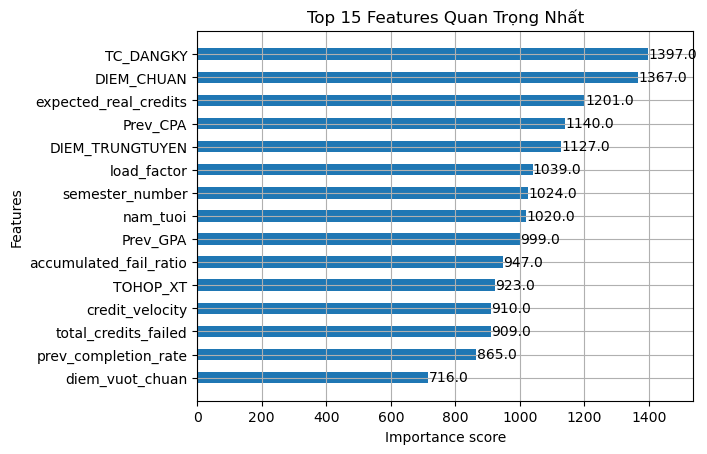

In [31]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

print("--- 🚀 3. TRAINING PHASE (XGBOOST) ---")

# ==============================================================================
# 1. CHUẨN BỊ DỮ LIỆU (SPLIT TRAIN/VALID)
# ==============================================================================
# Định nghĩa mốc thời gian theo đề bài
SPLIT_SEM = 20231  # Train đến hết HK1 2023-2024
VALID_SEM = 20232  # Valid là HK2 2023-2024

# Lọc dữ liệu từ full_df_fe (kết quả của bước Feature Engineering trước)
# Lưu ý: Loại bỏ các dòng Test ra khỏi quá trình train
df_modeling = full_df_fe[full_df_fe['set_type'] == 'TRAIN'].copy()

# Chia Train/Valid
train_mask = df_modeling['semester_order'] <= SPLIT_SEM
valid_mask = df_modeling['semester_order'] == VALID_SEM

X_train = df_modeling[train_mask][feature_cols]
y_train = df_modeling[train_mask]['COMPLETION_RATE'] # Train trên Rate
w_train = df_modeling[train_mask]['TC_DANGKY']       # (Optional) Trọng số: Môn nhiều tín quan trọng hơn

X_valid = df_modeling[valid_mask][feature_cols]
y_valid_rate = df_modeling[valid_mask]['COMPLETION_RATE']
y_valid_credits = df_modeling[valid_mask]['TC_HOANTHANH'] # Target thật (số tín) để đo RMSE
valid_credits_dangky = df_modeling[valid_mask]['TC_DANGKY'] # Dùng để convert Rate -> Credits

print(f"Kích thước tập Train: {X_train.shape}")
print(f"Kích thước tập Valid: {X_valid.shape}")

# ==============================================================================
# 2. CẤU HÌNH & TRAIN MODEL
# ==============================================================================
# XGBoost Parameters - Đã được tối ưu sơ bộ cho bài toán Regression
# ==============================================================================
# 2. CẤU HÌNH & TRAIN MODEL (ĐÃ SỬA LỖI)
# ==============================================================================
params = {
    'n_estimators': 2000,
    'learning_rate': 0.02,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:squarederror',
    'n_jobs': -1,
    'random_state': 42,
    'early_stopping_rounds': 100,
    
    # --- QUAN TRỌNG: PHẢI BẬT 2 DÒNG NÀY ---
    'enable_categorical': True,  # Cho phép xử lý cột category (PTXT, TOHOP_XT...)
    'tree_method': 'hist',       # Bắt buộc dùng 'hist' (hoặc 'gpu_hist') để hỗ trợ category tốt nhất
    # ---------------------------------------
}

model = xgb.XGBRegressor(**params)

print("\nĐang train model... (Vui lòng đợi)")
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid_rate)],
    verbose=200
)

# ==============================================================================
# 3. ĐÁNH GIÁ TRÊN TẬP VALID (QUAN TRỌNG)
# ==============================================================================
# Dự báo Rate
pred_rate_valid = model.predict(X_valid)

# HẬU XỬ LÝ (Post-Processing Strategy)
# 1. Clip Rate về [0, 1]
pred_rate_valid = np.clip(pred_rate_valid, 0, 1)

# 2. Convert về Số tín chỉ: Rate * TC_DANGKY
pred_credits_valid = pred_rate_valid * valid_credits_dangky

# 3. Hard Limit: Không bao giờ được vượt quá đăng ký (Dù model có sai số)
pred_credits_valid = np.minimum(pred_credits_valid, valid_credits_dangky)

# 4. Tính RMSE (Đơn vị: Tín chỉ)
rmse = np.sqrt(mean_squared_error(y_valid_credits, pred_credits_valid))
print(f"\n>>> RMSE trên tập Valid (HK2 2023-2024): {rmse:.4f}")
print("Note: RMSE càng thấp càng tốt. Nếu < 2.0 là khá ổn.")

# ==============================================================================
# 4. DỰ BÁO TẬP TEST & TẠO FILE NỘP
# ==============================================================================
print("\n--- 4. PREDICTING TEST SET (HK1 2024-2025) ---")
test_final = full_df_fe[full_df_fe['set_type'] == 'TEST'].copy()
X_test = test_final[feature_cols]
test_dangky = test_final['TC_DANGKY']

# Dự báo
pred_rate_test = model.predict(X_test)

# Hậu xử lý tương tự
pred_rate_test = np.clip(pred_rate_test, 0, 1)
pred_credits_test = pred_rate_test * test_dangky
pred_credits_test = np.minimum(pred_credits_test, test_dangky)

# Yêu cầu đề bài: Kết quả là số nguyên (Int) 
# Nhưng để an toàn cho RMSE, ta có thể round closest (làm tròn chuẩn)
final_submission = pred_credits_test

# Tạo DataFrame nộp bài
submission_df = pd.DataFrame({
    'MA_SO_SV': test_final['MA_SO_SV'],
    'PRED_TC_HOANTHANH': final_submission
})

# Lưu file
output_filename = 'submission_xgboost_v1.csv'
submission_df.to_csv(output_filename, index=False)
print(f"✅ Đã lưu file kết quả: {output_filename}")
print(submission_df.head())

# ==============================================================================
# 5. FEATURE IMPORTANCE (GIẢI THÍCH MODEL)
# ==============================================================================
plt.figure(figsize=(10, 8))
xgb.plot_importance(model, max_num_features=15, height=0.5)
plt.title("Top 15 Features Quan Trọng Nhất")
plt.show()

In [ ]:
# ==============================================================================
# 5. CHUẨN BỊ DỮ LIỆU CHO TRAINING (THE BRIDGE)
# ==============================================================================
print("\n--- ✂️ 3. SPLITTING TRAIN/VALID/TEST ---")

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# Định nghĩa mốc thời gian (Theo đề bài)
SPLIT_SEM = 20231  # Train đến hết HK1 2023-2024
VALID_SEM = 20232  # Valid là HK2 2023-2024

# Tạo Mask để lọc dữ liệu
# Lưu ý: train_final của bạn đang chứa cả Train và Valid
mask_train = train_final['semester_order'] <= SPLIT_SEM
mask_valid = train_final['semester_order'] == VALID_SEM

# 1. Định nghĩa tập TRAIN (Dùng để dạy model)
X_train = train_final[mask_train][feature_cols]
# Model học Tỷ lệ (Rate) chứ không học số tín chỉ -> Quy về [0, 1]
y_train = train_final[mask_train]['TC_HOANTHANH'] / (train_final[mask_train]['TC_DANGKY'] + 1e-9)
y_train = y_train.clip(0, 1)

# 2. Định nghĩa tập VALID (Dùng để kiểm tra & Stacking)
X_valid = train_final[mask_valid][feature_cols]
y_valid_rate = train_final[mask_valid]['TC_HOANTHANH'] / (train_final[mask_valid]['TC_DANGKY'] + 1e-9)
y_valid_rate = y_valid_rate.clip(0, 1)
# Các biến dùng để đo lường RMSE thực tế
y_valid_credits = train_final[mask_valid]['TC_HOANTHANH'] 
valid_dangky = train_final[mask_valid]['TC_DANGKY']

# 3. Định nghĩa tập TEST (Dùng để nộp bài)
X_test = test_final[feature_cols]
test_dangky = test_final['TC_DANGKY']

# Xác định danh sách cột Category cho CatBoost
# (Lấy từ feature_cols những cột nằm trong danh sách cat_cols của bạn)
cat_features_list = ['PTXT', 'TOHOP_XT', 'MA_NGANH', 'KV_UT', 'KHOA_VIEN']
valid_cat_features = [c for c in feature_cols if c in cat_features_list]

print(f"📌 Train size: {X_train.shape}")
print(f"📌 Valid size: {X_valid.shape}")
print(f"📌 Test size:  {X_test.shape}")
print(f"📌 Categorical Features: {valid_cat_features}")

# ==============================================================================
# 6. HUẤN LUYỆN STACKING ENSEMBLE (LAYER 1)
# ==============================================================================
print("\n--- 🚀 4. ACTIVATING STACKING ENSEMBLE ---")

# --- MODEL 1: XGBOOST ---
print("   -> Training XGBoost...")
xgb_params = {
    'n_estimators': 2000,
    'learning_rate': 0.02,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:squarederror',
    'n_jobs': -1,
    'random_state': 42,
    'enable_categorical': True, # Đã bật hỗ trợ category
    'tree_method': 'hist',
    'early_stopping_rounds': 100
}
model_xgb = xgb.XGBRegressor(**xgb_params)
model_xgb.fit(X_train, y_train, eval_set=[(X_valid, y_valid_rate)], verbose=False)

# --- MODEL 2: LIGHTGBM ---
print("   -> Training LightGBM...")
lgb_params = {
    'n_estimators': 2000,
    'learning_rate': 0.02,
    'num_leaves': 31,
    'objective': 'rmse',
    'metric': 'rmse',
    'n_jobs': -1,
    'random_state': 42,
    'verbose': -1
}
model_lgb = lgb.LGBMRegressor(**lgb_params)
model_lgb.fit(
    X_train, y_train, 
    eval_set=[(X_valid, y_valid_rate)], 
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
)

# --- MODEL 3: CATBOOST ---
print("   -> Training CatBoost...")
cat_params = {
    'iterations': 2000,
    'learning_rate': 0.02,
    'depth': 6,
    'loss_function': 'RMSE',
    'verbose': 0, # Tắt log cho gọn
    'random_state': 42,
    'allow_writing_files': False,
    'cat_features': valid_cat_features 
}
model_cat = CatBoostRegressor(**cat_params)
model_cat.fit(X_train, y_train, eval_set=(X_valid, y_valid_rate), verbose=False)

# ==============================================================================
# 7. LAYER 2: META-LEARNER (RIDGE REGRESSION) & PREDICTION
# ==============================================================================
print("\n--- 🔄 Layer 2: Blending & Prediction ---")

# 1. Tạo Meta-Features (Dự báo của 3 model trên tập Valid và Test)
def get_preds(model, X):
    return np.clip(model.predict(X), 0, 1)

# Predict Valid
pred_xgb_valid = get_preds(model_xgb, X_valid)
pred_lgb_valid = get_preds(model_lgb, X_valid)
pred_cat_valid = get_preds(model_cat, X_valid)

# Predict Test
pred_xgb_test = get_preds(model_xgb, X_test)
pred_lgb_test = get_preds(model_lgb, X_test)
pred_cat_test = get_preds(model_cat, X_test)

# 2. Xây dựng Dataset cho Layer 2
X_meta_valid = pd.DataFrame({'XGB': pred_xgb_valid, 'LGB': pred_lgb_valid, 'CAT': pred_cat_valid})
X_meta_test = pd.DataFrame({'XGB': pred_xgb_test, 'LGB': pred_lgb_test, 'CAT': pred_cat_test})

# 3. Train Meta-Learner (Ridge)
meta_model = Ridge(alpha=10.0)
meta_model.fit(X_meta_valid, y_valid_rate)

# Xem trọng số
weights = meta_model.coef_
print(f"📊 Trọng số Stacking: XGB: {weights[0]:.2f} | LGB: {weights[1]:.2f} | CAT: {weights[2]:.2f}")

# 4. Dự báo cuối cùng (Rate)
final_rate_valid = meta_model.predict(X_meta_valid)
final_rate_test = meta_model.predict(X_meta_test)

# ==============================================================================
# 8. HẬU XỬ LÝ & TẠO FILE NỘP (SUBMISSION)
# ==============================================================================

def post_process_credits(pred_rate, registered_credits):
    """Chuyển Rate -> Credits với các ràng buộc vật lý"""
    # Clip Rate
    pred_rate = np.clip(pred_rate, 0, 1)
    
    # Magic Trick: Nếu rất tự tin (>96%), đẩy lên 100%
    pred_rate[pred_rate >= 0.96] = 1.0
    
    # Convert ra tín chỉ
    pred_credits = pred_rate * registered_credits
    
    # Hard Limit: Không vượt quá đăng ký
    pred_credits = np.minimum(pred_credits, registered_credits)
    
    return pred_credits

# Đánh giá RMSE trên tập Valid
final_credits_valid = post_process_credits(final_rate_valid, valid_dangky)
rmse_stacking = np.sqrt(mean_squared_error(y_valid_credits, final_credits_valid))
print(f"\n>>> ✅ RMSE Stacking (Valid - HK2 23/24): {rmse_stacking:.4f}")

# Tạo file nộp bài cho Test (HK1 24/25)
final_credits_test = post_process_credits(final_rate_test, test_dangky)
final_submission = final_credits_test


submission_df = pd.DataFrame({
    'MA_SO_SV': test_final['MA_SO_SV'],
    'PRED_TC_HOANTHANH': final_submission
})

filename = 'submission_final_stacking.csv'
submission_df.to_csv(filename, index=False)
print(f"\n🎉 Đã xuất file thành công: {filename}")
print(submission_df.head())


--- ✂️ 3. SPLITTING TRAIN/VALID/TEST ---
📌 Train size: (90582, 24)
📌 Valid size: (15144, 24)
📌 Test size:  (16502, 24)
📌 Categorical Features: ['PTXT', 'TOHOP_XT']

--- 🚀 4. ACTIVATING STACKING ENSEMBLE ---
   -> Training XGBoost...
   -> Training LightGBM...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[266]	valid_0's rmse: 0.21248
   -> Training CatBoost...

--- 🔄 Layer 2: Blending & Prediction ---
📊 Trọng số Stacking: XGB: 0.22 | LGB: 0.29 | CAT: 0.49

>>> ✅ RMSE Stacking (Valid - HK2 23/24): 3.7427

🎉 Đã xuất file thành công: submission_final_stacking.csv
        MA_SO_SV  PRED_TC_HOANTHANH
2   00003e092652          14.947369
3   00027b0dec4c          17.174156
10  000e15519006          17.446657
13  000ea6e12003          15.980199
16  00109b845a3d           5.040422
